In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from gymnasium import spaces
import torch

## Load Traffic Environment

In [2]:
# Add the `src` folder to the Python path
# sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
current_working_directory = os.getcwd()
src_path = os.path.join(current_working_directory, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)
import environment_gym as env_gym
print("Import successful")

Import successful


## Create Evaluation and Test Function

In [3]:
def evaluate_model(log_path):
    """
    Reads the mean reward from the evaluation log and plots it to monitor convergence.

    Args:
    - log_path (str): Path to the directory containing the log file.
    """
    # Find the monitor CSV file generated by EvalCallback
    monitor_file = os.path.join(log_path, 'evaluations.npz')

    if not os.path.isfile(monitor_file):
        print("Error: Log file not found.")
        return

    # Load evaluation results
    results = np.load(monitor_file)
    mean_rewards = results['results'].mean(axis=1)  # Mean reward per evaluation

    # Plot the mean reward to observe convergence
    plt.plot(mean_rewards)
    plt.xlabel('Evaluation Step (x1000 timesteps)')
    plt.ylabel('Mean Reward')
    plt.title('Model Convergence')
    plt.show()

In [4]:
def test_model(model_path, env, num_episodes):
    """
    Evaluates the model over a specified number of episodes, records rewards for each episode,
    and plots the rewards.

    Args:
    - model_path (str): Path to the saved model.
    - env (gym.Env): The environment to evaluate the model on.
    - num_episodes (int): Total number of episodes to run the evaluation.

    Returns:
    - episode_rewards (list): List of total rewards for each episode.
    """
    # Load the model
    model = PPO.load(model_path)

    # Initialize a list to store rewards for each episode
    episode_rewards = []

    # Run the model for the specified number of episodes
    for episode in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0  

        while True:  # Run until the episode ends
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward  # Accumulate reward

            # Check if the episode is done
            if terminated or truncated:
                episode_reward = round(episode_reward)
                episode_rewards.append(episode_reward)  # Record total reward for the episode
                break  # Exit the loop to start a new episode

    # Calculate average reward
    reward_ave = round(sum(episode_rewards) / num_episodes)
    print(f"Average reward of {num_episodes} episodes is {reward_ave}.")
    
    # Plot the episode rewards
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode')
    plt.show()

    return episode_rewards

## Baseline PPO Agent

In [5]:
# Initialize and vectorize the environment
env = env_gym.TrafficEnvironment()
eval_env = Monitor(env_gym.TrafficEnvironment())

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO("MlpPolicy", env, verbose=1)

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/ppo_baseline_model',
    log_path='./logs/baseline_results',
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-11042.56 +/- 12805.92
Episode length: 1503.00 +/- 1281.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.5e+03  |
|    mean_reward     | -1.1e+04 |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-1410.68 +/- 2223.14
Episode length: 540.20 +/- 222.55
----------------------------------
| eval/              |           |
|    mean_ep_length  | 540       |
|    mean_reward     | -1.41e+03 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 293      |
|    ep_rew_mean     | 138      |
| time/              |          |
|    fps       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.02e+03 |
|    ep_rew_mean     | -8.7e+03 |
| time/              |          |
|    fps             | 242      |
|    iterations      | 6        |
|    time_elapsed    | 50       |
|    total_timesteps | 12288    |
---------------------------------
Eval num_timesteps=13000, episode_reward=-8780.56 +/- 16195.40
Episode length: 1278.40 +/- 1619.34
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.28e+03    |
|    mean_reward          | -8.78e+03   |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.008269003 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.811      |
|    explained_variance   | 0.00753     |
|    learning_rate        | 0.0003      |
|    loss      

Eval num_timesteps=24000, episode_reward=-2210.96 +/- 3627.07
Episode length: 621.20 +/- 362.68
----------------------------------
| eval/              |           |
|    mean_ep_length  | 621       |
|    mean_reward     | -2.21e+03 |
| time/              |           |
|    total_timesteps | 24000     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.01e+03  |
|    ep_rew_mean     | -7.88e+03 |
| time/              |           |
|    fps             | 235       |
|    iterations      | 12        |
|    time_elapsed    | 104       |
|    total_timesteps | 24576     |
----------------------------------
Eval num_timesteps=25000, episode_reward=1260.70 +/- 1669.28
Episode length: 275.20 +/- 166.31
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 275          |
|    mean_reward          | 1.26e+03     |
| time/                   |              |

Eval num_timesteps=35000, episode_reward=-4563.30 +/- 5169.89
Episode length: 856.60 +/- 516.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 857          |
|    mean_reward          | -4.56e+03    |
| time/                   |              |
|    total_timesteps      | 35000        |
| train/                  |              |
|    approx_kl            | 4.902249e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.34        |
|    explained_variance   | 0.318        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.75e+03     |
|    n_updates            | 170          |
|    policy_gradient_loss | -1.38e-06    |
|    value_loss           | 1.31e+04     |
------------------------------------------
Eval num_timesteps=36000, episode_reward=-4015.02 +/- 10263.92
Episode length: 802.40 +/- 1025.86
--------------------------------

Eval num_timesteps=47000, episode_reward=-11843.66 +/- 10945.67
Episode length: 1584.60 +/- 1094.36
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.58e+03  |
|    mean_reward     | -1.18e+04 |
| time/              |           |
|    total_timesteps | 47000     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 922       |
|    ep_rew_mean     | -6.24e+03 |
| time/              |           |
|    fps             | 235       |
|    iterations      | 23        |
|    time_elapsed    | 200       |
|    total_timesteps | 47104     |
----------------------------------
Eval num_timesteps=48000, episode_reward=-11168.60 +/- 11461.49
Episode length: 1517.20 +/- 1145.91
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 1.52e+03      |
|    mean_reward          | -1.12e+04     |
| time/                   |  

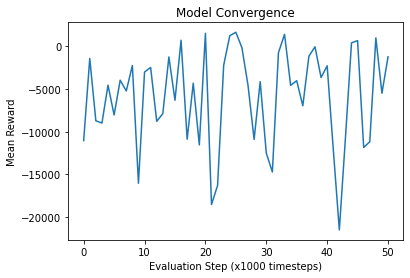

In [6]:
evaluate_model(log_path='./logs/baseline_results')

Average reward of 200 episodes is -6492.


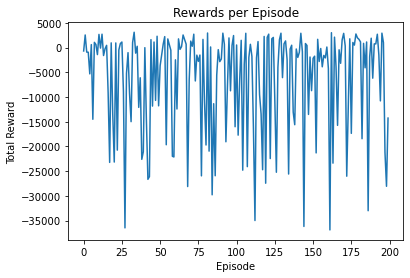

[-698,
 2539,
 -927,
 -949,
 -5330,
 589,
 -14510,
 1047,
 605,
 -1429,
 2653,
 -117,
 2696,
 -1619,
 -239,
 441,
 -9140,
 -23230,
 941,
 -13360,
 -23160,
 927,
 -20747,
 -486,
 810,
 1111,
 -8900,
 -36469,
 -5229,
 -1037,
 -9340,
 -14990,
 1005,
 3090,
 -1137,
 255,
 -12100,
 -6120,
 -22610,
 -21070,
 -26,
 -14480,
 -26650,
 -26100,
 1595,
 -11840,
 1113,
 -10690,
 2282,
 -11789,
 -3668,
 -1519,
 683,
 2206,
 -19660,
 1741,
 551,
 -556,
 -21989,
 -22128,
 -2484,
 -12430,
 1751,
 -371,
 185,
 2536,
 1614,
 680,
 -28110,
 -6570,
 1297,
 255,
 2696,
 -6760,
 -1535,
 -2799,
 -1519,
 -25949,
 1642,
 -10970,
 -19710,
 2937,
 -20949,
 115,
 -29780,
 -11360,
 -25929,
 -5579,
 -429,
 -2854,
 -2319,
 2906,
 662,
 -19059,
 -7900,
 1942,
 -8750,
 427,
 2421,
 -16019,
 514,
 -17718,
 -6639,
 1454,
 -24800,
 -3372,
 2881,
 -24089,
 -2004,
 651,
 -1774,
 -16319,
 -34980,
 -2090,
 1204,
 -9489,
 -13420,
 -24710,
 2241,
 -27439,
 2050,
 2705,
 -22450,
 1769,
 2042,
 -11000,
 -25220,
 -4010,
 1593,
 28

In [7]:
# Model testing
model_path = './logs/ppo_baseline_model/best_model.zip'
env_test = env_gym.TrafficEnvironment()
num_episodes = 200
test_model(model_path=model_path, env=env, num_episodes=num_episodes)

## Finetune PPO Agent

In [8]:
# Initialize and vectorize the environment
env = env_gym.TrafficEnvironment()
eval_env = Monitor(env_gym.TrafficEnvironment())

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/ppo_finetune_model',
    log_path='./logs/finetune_results',
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Define the PPO model with MlpPolicy
model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1,
    learning_rate=2.5e-4,         
    n_steps=4096,               
    batch_size=128,              
    gae_lambda=0.95,            
    gamma=0.99,                 
    clip_range=0.1,
    clip_range_vf=0.1,
    n_epochs=20,
    ent_coef=0.005,
    target_kl=0.01
)

# Train the PPO model
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-11555.22 +/- 9000.14
Episode length: 1445.00 +/- 846.41
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.44e+03  |
|    mean_reward     | -1.16e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-7989.50 +/- 14264.70
Episode length: 1067.60 +/- 1301.57
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.07e+03  |
|    mean_reward     | -7.99e+03 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
Eval num_timesteps=3000, episode_reward=-381.06 +/- 1398.12
Episode length: 371.40 +/- 129.75
---------------------------------
| eval/              |          |
|    mean_ep_le

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.27e+03  |
|    ep_rew_mean     | -1.26e+04 |
| time/              |           |
|    fps             | 262       |
|    iterations      | 4         |
|    time_elapsed    | 62        |
|    total_timesteps | 16384     |
----------------------------------
Eval num_timesteps=17000, episode_reward=-15623.04 +/- 19626.00
Episode length: 1960.40 +/- 1961.98
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.96e+03     |
|    mean_reward          | -1.56e+04    |
| time/                   |              |
|    total_timesteps      | 17000        |
| train/                  |              |
|    approx_kl            | 0.0031721347 |
|    clip_fraction        | 0.0581       |
|    clip_range           | 0.1          |
|    clip_range_vf        | 0.1          |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.0001

Eval num_timesteps=31000, episode_reward=-398.92 +/- 2797.31
Episode length: 439.20 +/- 279.16
---------------------------------
| eval/              |          |
|    mean_ep_length  | 439      |
|    mean_reward     | -399     |
| time/              |          |
|    total_timesteps | 31000    |
---------------------------------
Eval num_timesteps=32000, episode_reward=-13106.62 +/- 13367.35
Episode length: 1709.60 +/- 1335.74
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.71e+03  |
|    mean_reward     | -1.31e+04 |
| time/              |           |
|    total_timesteps | 32000     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.22e+03  |
|    ep_rew_mean     | -1.15e+04 |
| time/              |           |
|    fps             | 223       |
|    iterations      | 8         |
|    time_elapsed    | 146       |
|    total_timesteps | 32768     |
-------

Eval num_timesteps=46000, episode_reward=-3230.08 +/- 4781.02
Episode length: 722.20 +/- 477.95
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 722         |
|    mean_reward          | -3.23e+03   |
| time/                   |             |
|    total_timesteps      | 46000       |
| train/                  |             |
|    approx_kl            | 0.003879328 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.1         |
|    clip_range_vf        | 0.1         |
|    entropy_loss         | -0.831      |
|    explained_variance   | 0.000415    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.16e+04    |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00548    |
|    value_loss           | 2.6e+04     |
-----------------------------------------
Eval num_timesteps=47000, episode_reward=-10447.00 +/- 14285.94
Episode length: 1444.00 +/- 1428.16
------

Eval num_timesteps=61000, episode_reward=-9289.06 +/- 14017.32
Episode length: 1328.00 +/- 1400.91
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.33e+03  |
|    mean_reward     | -9.29e+03 |
| time/              |           |
|    total_timesteps | 61000     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.26e+03  |
|    ep_rew_mean     | -1.14e+04 |
| time/              |           |
|    fps             | 224       |
|    iterations      | 15        |
|    time_elapsed    | 273       |
|    total_timesteps | 61440     |
----------------------------------
Eval num_timesteps=62000, episode_reward=-10775.48 +/- 14648.94
Episode length: 1477.00 +/- 1464.27
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.48e+03     |
|    mean_reward          | -1.08e+04    |
| time/                   |       

Eval num_timesteps=75000, episode_reward=-7630.40 +/- 8360.92
Episode length: 1161.80 +/- 835.14
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.16e+03  |
|    mean_reward     | -7.63e+03 |
| time/              |           |
|    total_timesteps | 75000     |
----------------------------------
Eval num_timesteps=76000, episode_reward=-4994.44 +/- 9887.55
Episode length: 898.60 +/- 987.85
----------------------------------
| eval/              |           |
|    mean_ep_length  | 899       |
|    mean_reward     | -4.99e+03 |
| time/              |           |
|    total_timesteps | 76000     |
----------------------------------
Eval num_timesteps=77000, episode_reward=-9129.34 +/- 10631.80
Episode length: 1312.20 +/- 1062.31
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.31e+03  |
|    mean_reward     | -9.13e+03 |
| time/              |           |
|    total_timesteps | 77000     |
--------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -9.9e+03 |
| time/              |          |
|    fps             | 227      |
|    iterations      | 22       |
|    time_elapsed    | 395      |
|    total_timesteps | 90112    |
---------------------------------
Early stopping at step 0 due to reaching max kl: 0.02
Eval num_timesteps=91000, episode_reward=-13969.82 +/- 5986.27
Episode length: 1795.40 +/- 598.38
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.8e+03      |
|    mean_reward          | -1.4e+04     |
| time/                   |              |
|    total_timesteps      | 91000        |
| train/                  |              |
|    approx_kl            | 0.0033132776 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.1          |
|    clip_range_vf        | 0.1          |
|    entropy_loss         | -0.583 

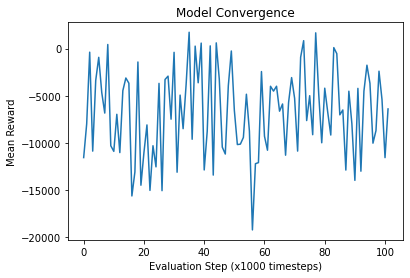

In [9]:
evaluate_model(log_path='./logs/finetune_results')

Average reward of 200 episodes is -6607.


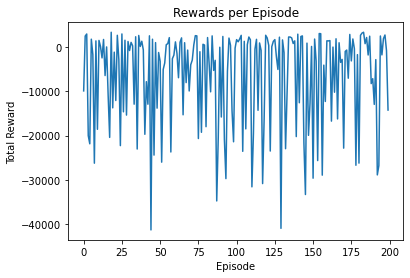

[-9909,
 2490,
 2956,
 -20034,
 -21874,
 1786,
 -1715,
 -26259,
 1399,
 -18593,
 1505,
 150,
 -2450,
 1719,
 -6440,
 34,
 -10820,
 -20424,
 3352,
 -13744,
 -1149,
 -12084,
 2664,
 -2844,
 -22284,
 2968,
 -14640,
 1547,
 -15380,
 1260,
 -782,
 1062,
 288,
 -12914,
 2333,
 -23055,
 2627,
 139,
 1319,
 -645,
 -19725,
 -7824,
 -12920,
 2546,
 -41344,
 1778,
 -24427,
 1011,
 -13810,
 -1229,
 -3200,
 -26024,
 -5059,
 -3590,
 535,
 787,
 2136,
 -23724,
 -2631,
 -1807,
 1174,
 -1422,
 -6932,
 1076,
 2078,
 -15314,
 987,
 -8034,
 -681,
 -9925,
 -3997,
 -2945,
 468,
 2582,
 2532,
 -20680,
 -1051,
 -19270,
 633,
 458,
 -18005,
 2152,
 -3560,
 -10120,
 2531,
 -5280,
 -2995,
 -34795,
 -20415,
 -39,
 -15814,
 2399,
 -20840,
 -29745,
 -5484,
 2035,
 410,
 -14389,
 -21415,
 -243,
 1685,
 1191,
 1828,
 2653,
 -23575,
 1300,
 -18495,
 546,
 2275,
 1655,
 -31605,
 -19610,
 -440,
 1750,
 -14300,
 931,
 -729,
 -30869,
 -16239,
 2670,
 2059,
 389,
 -23510,
 91,
 1291,
 1690,
 -2155,
 -5058,
 2241,
 -40990,


In [10]:
# Model testing
model_path = './logs/ppo_finetune_model/best_model.zip'
env_test = env_gym.TrafficEnvironment()
num_episodes = 200
test_model(model_path=model_path, env=env, num_episodes=num_episodes)

Training with parameters: {'batch_size': 64, 'gamma': 0.99, 'learning_rate': 0.001, 'n_steps': 1024, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -5098.985
New best model found with reward -5098.985
Training with parameters: {'batch_size': 64, 'gamma': 0.99, 'learning_rate': 0.001, 'n_steps': 2048, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -8186.191
Training with parameters: {'batch_size': 64, 'gamma': 0.99, 'learning_rate': 0.00025, 'n_steps': 1024, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -6615.198999999999
Training with parameters: {'batch_size': 64, 'gamma': 0.99, 'learning_rate': 0.00025, 'n_steps': 2048, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -5469.6720000000005
Training with parameters: {'batch_size': 64, 'gamma': 0.99, 'learning_rate': 0.0001, 'n_steps': 1024, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -7135.985000000002
Training with parameters: {'batch_size': 64, 'gamma': 0.99, 'learning_rate

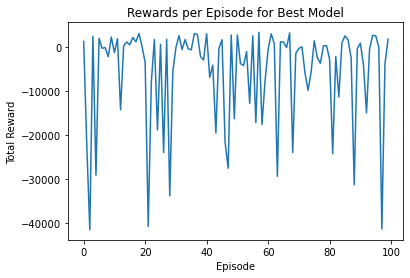

In [12]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
import numpy as np

param_grid = {
    'policy': ['MlpPolicy'],
    'learning_rate': [1e-3, 2.5e-4, 1e-4, 5e-5],
    'n_steps': [1024, 2048],
    'batch_size': [64, 128],
    'gamma': [0.99, 0.95]
}

env = env_gym.TrafficEnvironment()
eval_env = Monitor(env_gym.TrafficEnvironment())
best_reward = -float('inf')
best_params = None
best_model_path = "./best_model"
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    model = PPO(params['policy'], env, **{k: v for k, v in params.items() if k != 'policy'}, verbose=0)
    model.learn(total_timesteps=50000)
    obs, info = eval_env.reset()
    episode_rewards = []
    for _ in range(100):
        total_reward = 0
        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            total_reward += reward
            if terminated or truncated:
                episode_rewards.append(total_reward)
                obs, info = eval_env.reset()
                break
    mean_reward = np.mean(episode_rewards)
    print(f"Mean reward for current parameters: {mean_reward}")

    if mean_reward > best_reward:
        best_reward = mean_reward
        best_params = params
        model.save(best_model_path)
        print(f"New best model found with reward {best_reward}")

print(f"Best parameters found: {best_params}")
print(f"Best reward: {best_reward}")

plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode for Best Model')
plt.show()
